This notebook will now have 

1. Regression of Behavior + GCamp 

**Regression packages**

statsmodel 

edward

PYRO (noah goodman) 






In [2]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec


import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)



In [1]:
%load_ext rpy2.ipython
%R library(lme4)

/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)


array(['lme4', 'Matrix', 'tools', 'stats', 'graphics', 'grDevices',
       'utils', 'datasets', 'methods', 'base'],
      dtype='<U9')

In [3]:
%%time
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp.csv", index_col = 0) # .dropna(subset=['Q_dir_diff'])


df_trials = pd.read_csv("data/int_pc_qvals.csv", index_col = 0)


# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all

df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



CPU times: user 3.64 s, sys: 201 ms, total: 3.84 s
Wall time: 4.05 s


In [4]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
GCAMP_RANGE = np.arange(-1, 2, 1/dt)

# for trials in general 

NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

In [5]:
df_corr = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS'])
RECORDLOC = 'DMS'

In [6]:
# get the cuts + the binnings 

# constants: 
AVG_TIME_COURSE = np.arange(15, 30) # time course to average over. 15:30 corresponds to 0 to 1.0 seconds at timelock
Q_BINS = 10
Q_BINS_QUANTILES = Q_BINS

    
    
df_corr['max_np'] = [max(x) for x in df_corr['g_np']]
df_corr['max_lp'] = [max(x) for x in df_corr['g_lp']]
df_corr['max_ch'] = [max(x) for x in df_corr['g_choice']]
df_corr['max_r'] = [max(x) for x in df_corr['g_reward']]

df_corr['avg_np'] = [np.mean(x[AVG_TIME_COURSE], 0) for x in df_corr['g_np']]
df_corr['avg_lp'] = [np.mean(x[AVG_TIME_COURSE], 0) for x in df_corr['g_lp']]
df_corr['avg_lp'] = [np.mean(x[AVG_TIME_COURSE], 0) for x in df_corr['g_choice']]
df_corr['avg_r'] = [np.mean(x[AVG_TIME_COURSE], 0) for x in df_corr['g_reward']]


df_corr['bQ_dir_diff'] = pd.cut(df_corr['Q_dir_diff'], Q_BINS)
df_corr['bQ_ch_diff'] = pd.cut(df_corr['Q_ch_diff'], Q_BINS)

# quantile cuts for raw Q values 
df_corr['bQ_chosen'] = pd.qcut(df_corr['Q_chosen'], Q_BINS_QUANTILES)
df_corr['bQ_c'] = pd.qcut(df_corr['Q_c'], Q_BINS_QUANTILES)

# Note that Q_i below is not the most accurate way of getting it 
# Q_DIR_DIFF = Q_C - Q_I 
# Q_I =  Q_C - Q_DIR_DIFF 
# however --> these are the averaged values of Q_C and Q_DIR_DIFF. If you eventually want Q_i, you'll want to derive it from the 
# 3K samples of Q_i, then average. 

# df_corr['bQ_i'] = pd.qcut(df_corr['Q_c'] - df_corr['Q_dir_diff'], Q_BINS_QUANTILES)


# First Pass Regression



Regression to compute: 

Y ~ (X x Con/Ips) + (X x Con/Ips | Subject)

regress: GCaMP (max/avg) vs Q values (Q_contra - Q_ipsi THEN Q_chosen; Q_chosen - Q_unchosen) 
-- > interactions with (contra vs ipsi choice)  → for NaC and DMS  (get p values) 




In [7]:
%%R -i df_corr
print(summary(lmer('Weight ~ Time + (1|Pig)', data=dietox)))

UsageError: %%R is a cell magic, but the cell body is empty. Did you mean the line magic %R (single %)?


/Users/sasha/anaconda/envs/biomath/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [20]:
print(*df_corr.columns, sep='   ')

MouseID   Trial   Action   Reward   Stay/Leave   g_np   g_lp   g_choice   g_reward   Session   RecordLoc   Reward_last   Q_c   Q_dir_diff   Q_chosen   Q_ch_diff   max_np   max_lp   max_ch   max_r   avg_np   avg_lp   avg_r   bQ_dir_diff   bQ_ch_diff   bQ_chosen   bQ_c


In [22]:
lme4

NameError: name 'lme4' is not defined

In [7]:
## DROP THE NA VALUES !!! -- double check that the Q_c and Q_chosen makes sense 
formula = 'avg_lp ~  Q_chosen * Action'
mdf = mixedlm(formula, data=df_corr, groups=df_corr['MouseID'], #).fit()
             re_formula="~Q_chosen").fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM     Dependent Variable:     avg_lp    
No. Observations:      10108       Method:                 REML      
No. Groups:            12          Scale:                  0.3612    
Min. group size:       309         Likelihood:             -9243.4203
Max. group size:       1503        Converged:              Yes       
Mean group size:       842.3                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.118    0.039 -2.989 0.003 -0.195 -0.040
Action[T.Ips]               0.327    0.020 16.315 0.000  0.288  0.367
Q_chosen                    0.232    0.071  3.246 0.001  0.092  0.372
Q_chosen:Action[T.Ips]      0.031    0.032  0.974 0.330 -0.032  0.095
Intercept RE                0.016    0.013                           
Intercept RE x Q_chosen RE  0.001    0.016                           
Q_chosen RE                 0.055    0.043                           
=====================================================================

"""

# Diagnostics Scripts

In [ ]:
# test_data = sm.datasets.get_rdataset('dietox', 'geepack').data

# Simplest Regression 
formula = 'avg_lp ~  Q_chosen'
lm = ols(formula, data = df_corr).fit()
lm.summary()

formula = 'avg_lp ~  Q_chosen * Action' # with interaction



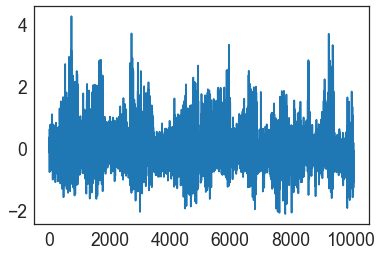

In [52]:
plt.plot(lm.resid)

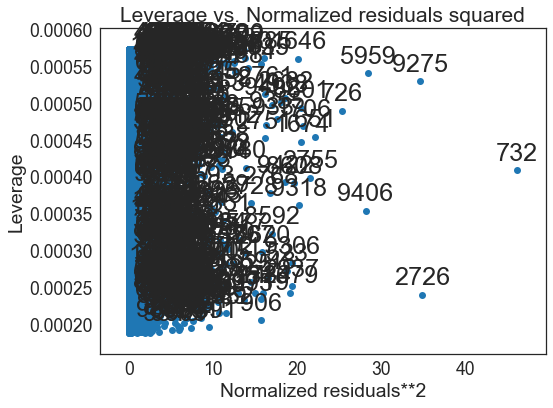

In [53]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(lm, ax = ax)

<StemContainer object of 3 artists>

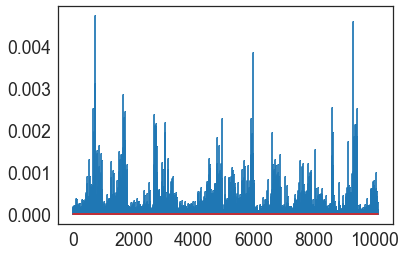

In [54]:
influence = lm.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
plt.stem(np.arange(len(c)), c, markerfmt=",")